In [1]:
import tables as tb
import pandas as pd
import numpy as np
import collections
from collections import namedtuple


from labelling.MClabelling import labelling_MC
from utils.labelling_utils import voxel_labelling_MC
from utils.histogram_utils import bin_creator, container_creator, mcimg
from utils.data_utils      import histog_to_coord
from utils.plotting_utils  import plot_3d_vox, plot_3d_hits

from utils.beersheba_labelling_utils import voxelize_beersh, merge_MC_beersh_voxels

from invisible_cities.io   import dst_io as dio

In [2]:
cutnum, num = '24', '6206'
directory   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'.format(cut = cutnum, num = num)

total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 2) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0

In [3]:
beersh_hits = dio.load_dst(directory, 'DECO', 'Events') 
detector_frame = container_creator(total_size, voxel_size)
detector_bins  = bin_creator(detector_frame, steps = voxel_size, x0 = start_bin)

Miramos un poco la separación entre las capas de la reconstruccion, y en Z luce que se alejan aprox 2mm (será ese el tamaño de voxel q tengo q usar??)

Efectivamente, por lo que entendí a gonzalo, será una especie de promedio de eso... Aunque me preocupa si da decimal porque que follón la voxelización decimal quizás... no sé si me dará algún fallo por el camino espero que no... Creo que le puse que fuera numeros enteros solo a los voxeles normalizados estos, una vez ya no aparece el tamaño del voxel en los bins en sí... no se...

Vale, algunas medias en Z dan grandes porque creo que son voxeles separados del evento, no es que en capas contiguas haya mucha diferencia... Entonces voy a no contar esas diferencias... No seemea muy legal pero pongo q si la diferencia es más de 4 pues no la cuento... pero lo hago porque sé que en las capas contiguas la cosa oscila alrededor de 2, sino nada

In [20]:
sumdif = 0
sumlay = 0
for nevent, df in beersh_hits.groupby('event'):
    nlayers = len(df.Z.unique()) - 1 #numero de 'capas' de Z en cada evento 
    for i in range(nlayers):
        dif = df.Z.unique()[i+1] - df.Z.unique()[i]
        if dif > 4:
            nlayers = nlayers - 1
        else:
            sumdif = sumdif + dif
    sumlay = sumlay + nlayers
print(sumdif / sumlay)

1.9659526830333764


## CAMBIE EN Z A 2 PORQUE ASÍ ESTÁN BINEADOS LOS VOXELES TRAS IRENE (noseque cosa de rebin de 2 microsegundos...).

Lo único que cambia notablemente es que tarda más el algoritmo de etiquetado, pero tampoco me extraña...

## EN XY AUNQUE ESTÉN RECONSTRUIDOS CON BINES DE TAMAÑO 1, ESTOS SE USAN PARA INTERPOLAR Y LUEGO EFECTIVAMENTE SE USAN BINES DE 5x5 (o incluso 15x15 le entendí a gonzalo, estar atento de esto...)

### VALE,  FUI A OTRA NOTEBOOK EN EL REPOSITORIO DE CLOUDS A VER UN POCO DE QUÉ IBA LA VAINA... AHORA QUE LO SÉ, VEO LAS HERRAMIENTAS QUE ME PUEDEN SERVIR PARA HACER EL LABELLING... VAMOALLÁ

# ETIQUETADO DE NEIGHBORS

In [4]:
#Etiquetado de hits MC, voxelización y etiquetado de voxeles MC
labelled_voxels, labelled_hits = labelling_MC(directory, total_size, voxel_size, start_bin, blob_ener_loss_th = 0.25)

#Voxelización de hits beersheba
beersh_voxels = voxelize_beersh(directory, total_size, voxel_size, start_bin, labelled_vox = labelled_voxels)

#Unión de voxeles MC y beersheba y corrección de discrepancias
mc_beersh_voxels = merge_MC_beersh_voxels(labelled_voxels, beersh_voxels)

Vale, voy a probar con un evento a hacer lo de los histogramas y blablabla...

In [81]:
event = mc_beersh_voxels[mc_beersh_voxels.event_id == 48000044]

Reduzco los bins a valores 1 a 1 por rehacer el histograma, ya que no puede ser que tenga los bines con cierto voxel size (5) y las coordenadas de 1 en 1 tusabe... Lo que hace JA es en vez de guardarse las coordenadas de 1 en 1 (en ningún momento las usaba, yo sí para plotear los voxeles, además de que es sencillo volver a las otras coordenadas), se guarda los centros de los voxeles. Podría ser otra opción complementaria, pero en principio con tener cuidado y darme cuenta de que tienen q estar en la misma escala no debería pasar nada.

In [5]:
def scale_bins(bins, voxel_size):
    '''
    Scales the detector bins to unitary bins. If the input are already unitary bins, it does nothing.
    
    Args:
        bins: LIST OF ARRAYS
    Usually, detector bins to be normalized.
    
        voxel_size: TUPLE
    Size of the voxels in each dimension.
    
    RETURNS:
        bins: LIST OF ARRAYS
    Returns the unitary bins.
    '''
    size = [abs(b[1] - b[0]) for b in bins]
    is_scaled = [True if s == 1 else False for s in size]
    if not np.array(is_scaled).any():
        bins = [b / s for b, s in zip(bins, voxel_size)]
    return bins

In [83]:
#scale_bins(detector_bins, voxel_size)

In [84]:
coords = np.array(event[['x', 'y', 'z']])
bins = [b / s for b, s in zip(detector_bins, voxel_size)]

In [85]:
segm_beersh_histo, _ = np.histogramdd(coords, bins)

In [86]:
ndim = segm_beersh_histo.ndim

In [87]:
ndim

3

In [88]:
voxel_positions = segm_beersh_histo.nonzero() #análogo a crear una mascara, como hacía JA... quizás es más 
#ilustrativo lo de la mascara que esto no se...

In [89]:
#segm_beersh_histo[segm_beersh_histo.nonzero()]

Empezar aca la segunda lap creo

Las etiquetas las vamos a hacer de forma que se correspondan con sus originales sumando 3 simplemente:

In [90]:
label_dict={'rest':1, 'track':2, 'blob':3}

In [91]:
corresp_label_dict = {'nrest':'rest', 'ntrack':'track', 'nblob':'blob'}

In [6]:
def assign_nlabels(label_dict = {'rest':1, 'track':2, 'blob':3}, 
                   corresp_label_dict = {'nrest':'rest', 'ntrack':'track', 'nblob':'blob'}):
    '''
    Creates a dictionary that links the pure segclasses with their neighbour ones.
    
    Args:
        label_dict: DICT
    Has the original class names with their corresponding number.
    
        corresp_label_dict: DICT
    Has the correspondance between the neighbour class names and the pure class names.
    
    RETURNS:
        nlabel_dict: DICT
    Has the correspondance between pure seclass number and neighbour segclass number.
    '''
    
    nlabel_dict = {}
    for nclass in corresp_label_dict.keys():
        label = label_dict[corresp_label_dict[nclass]]
        nlabel_dict[label] = label + len(label_dict) #le sumo el numero de etiquetas que hay... que obviamente son 3 para nosotros
    return nlabel_dict

In [93]:
nlabel_dict = assign_nlabels()

In [94]:
nlabel_dict

{1: 4, 2: 5, 3: 6}

In [95]:
nlabel_dict[label_dict[corresp_label_dict['nrest']]]

4

In [7]:
def moves(ndim):
    '''
    Function that returns all the movements from one voxel to its neighbours (we consider a neighbour if a part of
    the voxel touches another, i.e. for 3dim faces are first neighbours, edges are second and vertex are third, and
    we consider them all).
    
    Args:
        ndim: INT
    Number of dimensions of the movements.
    
    RETURNS:
        vs: LIST
    Contains all the posible unitary movements to the neighbours.
    '''
    u0 = np.zeros(ndim)
    def u1(idim):
        ui1 = np.zeros(ndim)
        ui1[idim] = 1
        return ui1.astype(int)

    vs = (u0, u1(0), -1 * u1(0))
    for idim in range(1, ndim):
        us = (u0, u1(idim), -1 * u1(idim))
        vs = [(vi + ui).astype(int) for vi in vs for ui in us]
    vs.pop(0)

    return vs

## COMIENZA EL BUCLE DE ETIQUETADO

Así REEMPIEZA la cadena... rollo ahora con poner nrest, ntrack... pues obtengo el número de label que se le corresponde:

In [129]:
voxel_segclass = event.segclass #importante correr esta tb

In [130]:
seg_unique = voxel_segclass.unique()

In [131]:
seg_unique = np.sort(seg_unique[~np.isnan(seg_unique)])

In [132]:
seg_unique

array([2., 3., 5., 6.])

In [133]:
nbour_counts = []
for seg in range(1, int(max(seg_unique)) + 1):
    #Create an empty histogram for each class to fill
    counts = np.zeros(detector_frame.shape)
    #Create the mask for the specific class
    segclass_mask = voxel_segclass == seg
    #Now we select the coords that have that specific class 
    selected_coor = coords[segclass_mask]
    for move in moves(ndim):
        #We use norm coordinates, so it is not necessary to add the step to move the coordinates
        coors_next     = selected_coor + move
        #We count how many of one specific segclass are in that move
        counts_next, _ = np.histogramdd(coors_next, bins)
        #We add to the empty histogram the counts, in each step will be adding for a new move...
        counts         = counts + counts_next
    #Finally we select the values of the beersheba coordinates (because when moving we filled non existing voxels)
    
    nbour_counts.append(counts[voxel_positions])

IMPORTANTE recorrer desde la clase más baja posible (1 siempre) hasta la más alta en cada caso (a vecess 1, a veces 3 en el primer loop; a veces sabe dios ya en el segundo loop), pasando por todas las clases entre ellas. Si no no funciona bien el etiquetado

In [134]:
print(seg_unique)
for i in range(1, int(max(seg_unique)) + 1):
    print(i)

[2. 3. 5. 6.]
1
2
3
4
5
6


In [8]:
def count_neighbours(voxel_segclass, coords, bins):
    '''
    Counts the number of neighbours of each class a voxel has. The neighbour count is performed by moving all 
    the voxels a certain position. For each class, the function will make N movements to all the neighbours 
    (26 for 3 dimensional data), in each movement it performs an histogram to count. We add the histograms 
    corresponding to the same class in each step, and finally select the desired voxels (only those that exist 
    in the event, i.e. that have a beersheba energy associated).
    
    Args:
        voxel_segclass: PANDAS SERIES
    Segclass column of the event dataframe to know which classes are going to participate in the counting.
    
        coords: NUMPY ARRAY
    Has the coordinates of the beersheba voxels. It's shaped as (N, d), with N the number of voxels and d the 
    dimensions.
    
        bins: LIST OF ARRAYS
    Normalized bins for each dimension.
    
    RETURNS:
        nbour_counts: LIST
    Has the number of neighbour voxels per class one voxel has. It is a list of arrays, where each array 
    corresponds to a class (the first position is the class 1 - rest, etc).
    '''
    
    model_histo, _ = np.histogramdd(coords, bins)
    #This is like creating a mask for the positions of the voxels, for the count
    voxel_positions = model_histo.nonzero() 
    #Take the segclass values, deleting NaN
    seg_unique = voxel_segclass.unique()
    seg_unique = np.sort(seg_unique[~np.isnan(seg_unique)])
    #List to append neighbour counts for each segclass
    nbour_counts = []
    #We need to use all the classes in the range avaliable, otherwise our algorithm will mix classes (because 
    #we use positions of the counts to recognize the class)
    for seg in range(1, int(max(seg_unique)) + 1):
        #Create an empty histogram for each class to fill
        counts = np.zeros(model_histo.shape)
        #Create the mask for the specific class
        segclass_mask = voxel_segclass == seg
        #Now we select the coords that have that specific class 
        selected_coor = coords[segclass_mask]
        ndim = len(bins)
        for move in moves(ndim):
            #We use norm coordinates, so it is not necessary to add the step to move the coordinates
            coors_next     = selected_coor + move
            #We count how many of one specific segclass are in that move
            counts_next, _ = np.histogramdd(coors_next, bins)
            #We add to the empty histogram the counts, in each step will be adding for a new move...
            counts         = counts + counts_next
        #Finally we select the values of the beersheba coordinates (because when moving we filled non existing voxels)
        nbour_counts.append(counts[voxel_positions])
    return nbour_counts

Obviamente en la primera vuelta, muchos voxeles solo se llenan con algunos de sus vecinos porque otros son clase nan!!! (rollo sus cuentas no dan 26 como darían los voxeles centrales si contáramos todos los voxeles!!) Ahora lo que hay que hacer es en las posiciones en las que los voxeles sean nan (ver con una máscara cuales son vacíos) 
comparar coordenada a coordenada cual es el mayoritario y asignarle una clase vecina

Si se da el caso de que para un voxel dos clases tienen el mismo score, siempre preferiremos la clase ''superior'', es decir, blob > track > rest

In [136]:
null_mask = voxel_segclass.isnull()

Vale aquí pasa una thing... Si un voxel de los nulos no se llena, yo igualmente voy a coger una de las clases porque voy a tener un elemento que es [0, 0, 0] y me va a escoger blobclass porque hice que escogiera el último valor de todos... well a ver como arreglo esto

Tengo como hacer algo rollo... buscar los que están a 0... eliminarlo y en la mascara cambiar un True por un False para que luego no me llene ese valor en el df

In [137]:
class_scores = np.array(nbour_counts).T[null_mask] #estos son los scores de cada clase SOLO para los voxeles nan

Algo pasa acá, se está haciendo mal la parte de nbour_counts porque los counts de los histos ultimos están vacíos

NA YA ESTÁ, no habia corrido la casilla importante coñe

In [138]:
class_scores

array([[ 0.,  0.,  0.,  0., 13.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  1.],
       [ 0.,  0.,  0.,  0.,  2.,  6.],
       [ 0.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  6.]])

In [139]:
len(class_scores) == sum(null_mask)

True

In [140]:
empty_positions = [i for i, score in enumerate(class_scores) if (score == np.zeros(len(score))).all()]
empty_positions

[]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 55, 103, 104, 123, 124, 150, 225, 228]


In [141]:
#empty_positions = [0, 2] #esta es para probar

In [142]:
valor_final = len(class_scores) - len(empty_positions)

Aqui elimino de la lista de las scores aquellas que eran todas 0

In [143]:
class_scores = np.delete(class_scores, empty_positions, axis = 0)

Aquí vuelvo falsas aquellas posiciones en la mascara que eran true por ser nulas pero no las llenamos por no tener ningún vecino para llenarlas!!

In [144]:
null_index = voxel_segclass[null_mask].index
#null_mask[null_mask == True].index #de la máscara, cojo solo los índices de los elementos null, que 
#son los true
#este anterior era una forma tontisima de complicarme la vida xd

In [145]:
empty_index = null_index[empty_positions] #estos indices null ahora con las posiciones que hallé antes van a resultar ser los 
#voxeles deseados!!!
empty_index

Int64Index([], dtype='int64')

[1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1415,
            1465, 1466, 1500, 1501, 1530, 1629, 1632]

In [146]:
null_mask[empty_index] = ~null_mask[empty_index]

In [147]:
sum(null_mask)

9

In [148]:
#class_scores

In [149]:
valor_final == len(class_scores)

True

In [150]:
len(class_scores) == sum(null_mask)

True

Como usar argmax para los voxeles que tienen scores coincidentes no me sirve (porque escoje el primer score, y nosotros queremos el último máximo repetido), estoy buscando una alternativa

En principio, busco en cada voxel las posiciones de los maximos... En los repetidos, dará una lista con los 2 o 3 elementos que contengan maximos, y yo escojo de esos el maximo, teniendo así el resultado que quería :)

In [151]:
class_values = [np.where(score == score.max())[0].max() + 1 for score in class_scores]
# #+1 for the number to coincide with the class

In [152]:
class_values

[5, 5, 5, 5, 5, 5, 6, 6, 6]

Vale lo siguiente me da las posiciones dentro del array nclass, y en cada elemento los elementos que tienen mayor valor. En los casos en los que están repetidos, como por ejemplo el 11, aparece 2 veces. Mi misión ahora es que de esos repetidos, quedarme con el mayor de los dos, que obviamente es el último de los que aparecen...

Esta alternativa la abandoné un poco la vd, era mucho rollo

In [153]:
#nclass_max_values = np.where((nclass_scores.T == nclass_scores.max(axis = 1)).T)
#nclass_max_values

Ahora en nclass values ya tengo los voxeles que estaban vacíos con la clase vecina más frecuente que tienen!! Me falta convertirlos con el diccionario y appendearlos

In [154]:
nclass_values = [nlabel_dict[classv] if np.isin(classv, list(nlabel_dict.keys())) else classv for classv in class_values] #we could just add 3 to each value but it seems 
#more elegant this way with the dict
#the condition is for the next laps; in the first all values in class_values are 1, 2, 3 but in the second lap,
#they are not

Creamos un df con las nuevas segclasses que sustituiremos en el df anterior, por ello le damos los mismos índices...

In [155]:
nclass_df = pd.DataFrame({'segclass':nclass_values}, index = voxel_segclass[null_mask].index)

In [156]:
event = event.merge(nclass_df, left_index=True, right_index=True, how = 'outer')

In [157]:
event['segclass'] = event['segclass_y'].fillna(event['segclass_x'])
event = event.drop(['segclass_x', 'segclass_y'], axis = 1)

In [158]:
sum(event.segclass.isnull()) == len(empty_positions) #y como vemos se cumple que nos quedan esos voxeles vacíos!!

True

In [9]:
def fill_df_with_nbours_ordered(mc_beersh_event, nbour_counts, nlabel_dict):
    '''
    This function takes the neighbour counts scores for each empty voxel and assigns them their correspondent 
    neighbour class. If one voxel has no scores, it's ignored and remains empty (will be filled afterwards,
    looping on this function). If two classes are tied, the function chooses the most important one.
    (blob > track > rest).
    
    Args:
        mc_beersh_event: DATAFRAME
    Contains one event from the merge_MC_beersh_voxels function output.
          
        nbour_counts: LIST
    Output of the count_neighbours function, which has the number of neighbour voxels per class one voxel has.
    It is a list of arrays, where each array corresponds to a class (the first position is the class 1 - rest, etc).
    Each array has the counts of the number of neighbours for every beersheba voxel.
        
        nlabel_dict: DICT
    Contains the segclass correspondances between the main and the neighbour class.
        
    RETURNS:
        mc_beersh_event: DATAFRAME
    The event's segclass column is filled with the desired classes. It has the same structure as the input one.
    '''
    
    #We take the segclass column
    voxel_segclass = mc_beersh_event.segclass
    #Know whick of the rows in the DF are to fill
    null_mask = voxel_segclass.isnull()
    #Score for each segclass (number of neighbors that a voxel has of each class)
    class_scores = np.array(nbour_counts).T[null_mask]  
    assert len(class_scores) == sum(null_mask), 'Something failed in the count_neighbours function'
        
    empty_positions = [i for i, score in enumerate(class_scores) if (score == np.zeros(len(score))).all()]
    final_val = len(class_scores) - len(empty_positions) #to check things
        
    #Deleting the ones empty
    class_scores = np.delete(class_scores, empty_positions, axis = 0)
    assert final_val == len(class_scores), 'Something failed with the empty count voxels'
        
    #Index of the null segclass values (the ones with true in the mask ofcourse)
    null_index = voxel_segclass[null_mask].index 
    
    #Indexes of the empty voxels that had no neighbour with class
    empty_index = null_index[empty_positions]
    
    #Changing the mask to ignore the ones empty
    null_mask[empty_index] = ~null_mask[empty_index]
    assert len(class_scores) == sum(null_mask), 'Something failed excluding empty values of the dataframe'
        
    #Take the position of the most counted segclass; in case of ties, it chooses the most important (3>2>1)
    class_values = [np.where(score == score.max())[0].max() + 1 for score in class_scores]
    
    #Transforms the pure classes into neighbour classes; if it's already a neighbour it stays this way
    nclass_values = [nlabel_dict[classv] if np.isin(classv, list(nlabel_dict.keys())) else classv for classv in class_values]
        
    #DF with the new labelled voxels, with the same indexes as the original DF
    nclass_df = pd.DataFrame({'segclass':nclass_values}, index = voxel_segclass[null_mask].index)
    
    #Join DF and do cleaning
    mc_beersh_event = mc_beersh_event.merge(nclass_df, left_index=True, right_index=True, how = 'outer')
    mc_beersh_event['segclass'] = mc_beersh_event['segclass_y'].fillna(mc_beersh_event['segclass_x'])
    mc_beersh_event = mc_beersh_event.drop(['segclass_x', 'segclass_y'], axis = 1)
    assert sum(mc_beersh_event.segclass.isnull()) == len(empty_positions), 'Something failed excluding the empy voxels'
    
    return mc_beersh_event, empty_index

In [160]:
sum(event.segclass.isnull()) == 0

True

## SI HACIENDOLO A MANO ESTO DA FALSE, VOLVER ARRIBA A EMPEZAR EL ''BUCLE''

# FUNCION FINAL POR EVENTO

In [14]:
def label_neighbours_ordered(mc_beersh_event, bins, voxel_size, nlabel_dict, ghost_class = 7):
    '''
    Takes an event of beersheba primary labelled (only with the main segclass) and assigns neighbour 
    classes to the empty voxels. It uses the fill_df_with_nbours_ordered function, that particularly fills
    the missing voxels based just on the order they appear in the neighbour algorythm.
    
    Args:
        mc_beersh_event: DATAFRAME
    Contains one event from the merge_MC_beersh_voxels function output.
    
        bins: LIST OF ARRAYS
    Detector bins, although they will be scaled to unity bins to work in this function.
        
        voxel_size: TUPLE
    Size in each dimension for the voxels.    
        
        nlabel_dict: DICT
    Contains the segclass correspondances between the main and the neighbour class.
        
    RETURNS
        mc_beersh_event: DATAFRAME
    The event's segclass column is filled with the desired classes. It has the same structure as the input one.
    '''
    
    coords = np.array(mc_beersh_event[['x', 'y', 'z']])
    bins = scale_bins(bins, voxel_size) 
    
    voxel_segclass = mc_beersh_event.segclass
    empty_index = []
    while sum(voxel_segclass.isnull()) != 0:
        nbour_counts    = count_neighbours(voxel_segclass, coords, bins)
        mc_beersh_event, empty_index_new = fill_df_with_nbours_ordered(mc_beersh_event, nbour_counts, nlabel_dict)
        
        #If the previous empty voxels were the same as the current ones, we will label them as ghost class
        #We check that the lists have the same lenght because if they don't, the comparison of values will
        #return an error
        if len(empty_index) == len(empty_index_new) and (empty_index == empty_index_new).all():
            mc_beersh_event.segclass = mc_beersh_event.segclass.replace(to_replace = np.nan, value = ghost_class)
                
        #Update the condition and the list of empty index
        voxel_segclass  = mc_beersh_event.segclass
        empty_index = empty_index_new
        
    #Turn into an integer
    mc_beersh_event.segclass = pd.to_numeric(mc_beersh_event.segclass, downcast = 'integer')
    return mc_beersh_event
        

In [188]:
sum(voxel_segclass.isnull() != 0)

5

In [190]:
event.segclass = pd.to_numeric(event.segclass, downcast = 'integer')

In [191]:
event

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
321,48000026,0,-12,55,0.000526,0,NaN,NaN,5
322,48000026,0,-11,55,0.001516,0,NaN,NaN,5
323,48000026,0,-10,55,0.002050,0,NaN,NaN,4
324,48000026,0,-9,55,0.000820,0,NaN,NaN,5
325,48000026,1,-14,55,0.000162,0,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...
450,48000026,8,-16,54,0.002355,0,NaN,NaN,6
451,48000026,8,-16,55,0.006020,0,NaN,NaN,6
452,48000026,8,-15,54,0.000498,0,NaN,NaN,6
453,48000026,9,-18,55,0.001893,0,NaN,NaN,6


In [15]:
mc_beersh_event = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[2]]

final_event = label_neighbours_ordered(mc_beersh_event, detector_bins, voxel_size, nlabel_dict)

In [16]:
      event2 = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[3]]

final_event2 = label_neighbours_ordered(event2, detector_bins, voxel_size, nlabel_dict)

EVENTO A MIRAR PORQUE NO SE ETIQUETABA (supongo q es porque hay voxeles reconstruidos leganos... quizás debería poner un límite de iteraciones o así y esos voxeles que se jodan, o asignarle una clase extra nueva rollo RECONSTRUCTION THINGY

In [17]:
      event3 = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[4]]
    
final_event3 = label_neighbours_ordered(event3, detector_bins, voxel_size, nlabel_dict)

In [18]:
      event4 = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[5]]

final_event4 = label_neighbours_ordered(event4, detector_bins, voxel_size, nlabel_dict)

In [19]:
      event5 = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[7]]

final_event5 = label_neighbours_ordered(event5, detector_bins, voxel_size, nlabel_dict)

Vemos que el labelleado de neighbours no haya cambiado NADA de los voxeles originales... luce que no

## SOLUCIÓN VOXELES FANTASMAS

Vale, voy a tener que adaptar la función. Creo que la forma más fácil podría ser contar simplemente si los voxeles siguen sumando 0 vecinos de voxeles con already a class... Entonces esos decir pues nada, les asigno una clase extra que se llama clase fantasma y a tomar viento... la nueva CLASS 7........ shaking. 

No sé si hacerlo tras varias iteraciones, rollo poner de máximo 10 (más que eso no creo que le cueste al nene llegar, malo será que haya nubes tan gordas no? 

QUIZÁS MEJOR, cuando vea que los voxeles que excluyo (que eran aquellos que no tenían vecinos) son los mismos en dos loops distintas, AHI aplicar la nueva class a dichos voxeles... no está mal...

Esto último tendrá que ser haciendo una especie de return en la función de llenado del df con esas labels... lets see

vale, hice que el bicho me returneara los indices q no se llenaban con nada, los guardo y los comparo con la siguiente loop; si son iguales, cojo el df y lleno todos sus NaN con ghost_class y voilà

# Funcion para juntar todo

Solo nos faltaría ahora una función para que haga el etiquetado de neighbours evento por evento y me devuelva el df de todo el fichero con las clases por evento... Es decir, aplicar estas funciones que hice en un groupby y mergear con el df sin etiquetar los neighbours 

COMPROBAR si el merge me da el mismo DF (al aislar el evento) que el que producen las funciones, lo típico...

In [4]:
from time import time
from utils.beersheba_labelling_utils import *

In [5]:
def labelling_beersheba(beersh_dir, total_size, voxel_size, start_bin, labelled_MC_voxels, label_neighbours_function, simple = True, relabel = True):
    '''
    Takes the beersheba file, voxelizes its hits and labels them with the help of the labelled MC voxels, the 
    output of the labelling_MC function.
    
    Args:
        beersh_dir: STR
    Directory of the beersheba file.
    
        total_size: TUPLE 
    Contains the max size of the detector.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate.
    
        start_bin: TUPLE
    Contains the first voxel position for each coordinate.
    
        labelled_MC_voxels: DATAFRAME
    Contains the MC data labelled voxels that will be the base of the labelling.
    
        label_neighbours_function: FUNCTION
    Selected function to perform the neighbour labelling (so I can easily change the method)
    
        simple: BOOL
    If True, in the voxelization we will only use hits energy information. Else, the voxelization would include 
    the information of some feature (with its ratio), which in beersheba data it's just the npeak variable. I 
    don't really know if this is an important information.
    
        relabel: BOOL
    If True, the merge_MC_beersh_voxels would try to include the external MC labelled voxels to some empty beersheba
    voxels, so we can benefit from this information. Else, this info will be lost and we would stick only to the 
    true coincident voxels.
    
    RETURNS:
        mc_beersh_voxels: DATAFRAME
    Contains all the beersheba labelled voxels. It has their positions, energies, segclass, binclass; ener and ratio
    values are also included but only the MC voxels have them
    '''
    detector_frame = container_creator(total_size, voxel_size)
    detector_bins  = bin_creator(detector_frame, steps = voxel_size, x0 = start_bin)
    
    nlabel_dict = assign_nlabels()
    
    #Beersheba hits voxelization
    beersh_voxels = voxelize_beersh(beersh_dir, total_size, voxel_size, start_bin, labelled_vox = labelled_MC_voxels, simple = simple)

    #Joining of the MC and beersheba voxels, and discrepancies correction
    mc_beersh_voxels = merge_MC_beersh_voxels(labelled_MC_voxels, beersh_voxels, relabel = relabel)

    for event_id, df in mc_beersh_voxels.groupby('event_id'):
        #if event_id % 50 == 0:
        #    print(event_id)
    
        event_neighbours_labelled = label_neighbours_function(df, detector_bins, voxel_size, nlabel_dict)
        mc_beersh_voxels = mc_beersh_voxels.merge(event_neighbours_labelled.segclass, 
                                                  left_index = True, 
                                                  right_index = True, 
                                                  how = 'outer')
        mc_beersh_voxels['segclass'] = mc_beersh_voxels['segclass_y'].fillna(mc_beersh_voxels['segclass_x'])
        mc_beersh_voxels = mc_beersh_voxels.drop(['segclass_x', 'segclass_y'], axis = 1)
    
        #Check if the labelling has sense (just check that all the new classes are consistent to the original ones)
        unique_seg = df.segclass.unique()[~np.isnan(df.segclass.unique())]
        for i in unique_seg:
            unique_seg = np.append(unique_seg, i + 3)
        unique_seg = np.append(unique_seg, 7)
        assert (np.isin(mc_beersh_voxels[mc_beersh_voxels.event_id == event_id].segclass, unique_seg)).all()
    
        #Check that the merge was sucessful
        assert pd.to_numeric(mc_beersh_voxels[mc_beersh_voxels.event_id == event_id].segclass, downcast = 'integer').equals(event_neighbours_labelled.segclass)
    
    #Turn into an integer
    mc_beersh_voxels.segclass = pd.to_numeric(mc_beersh_voxels.segclass, downcast = 'integer')
    return mc_beersh_voxels
    

In [6]:
start = time()
labelled_MC_voxels, labelled_hits = labelling_MC(directory, total_size, voxel_size, start_bin, blob_ener_loss_th = 0.25)
print(time()-start)
start = time()
labelled_beersheba = labelling_beersheba(directory, 
                                         total_size, 
                                         voxel_size, 
                                         start_bin, 
                                         labelled_MC_voxels, 
                                         label_neighbours_ordered, 
                                         simple = True, 
                                         relabel = True)
print(time() - start)

53.79417300224304
693.9113800525665


In [17]:
labelled_beersheba

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
0,48000024,-1,32,144,0.000357,0,NaN,NaN,4
1,48000024,-1,33,144,0.000561,0,0.029452,1.0,1
2,48000024,-1,33,145,0.002432,0,NaN,NaN,4
3,48000024,0,32,144,0.001903,0,NaN,NaN,4
4,48000024,0,32,145,0.000442,0,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...
173847,48000597,8,-5,151,0.000654,0,NaN,NaN,5
173848,48000597,8,-4,149,0.000611,0,0.011978,1.0,2
173849,48000597,8,-4,150,0.005414,0,0.008966,1.0,2
173850,48000597,9,-5,149,0.000636,0,NaN,NaN,5


Vale, parece que está todo en orden. Debería documentarla y palante non?? La meto en un archivo q se llame beersh labelling o algo así, hago los imports necesarios y palante... Luego haré una que sea label data donde junte estas dos y palante tb... Mirar las funciones de plot de añadirlas tb :)

# PLOTS

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [19]:
def plot_label_creator(min_vals, max_vals, voxel_size, affluence):
    '''
    Function to create ticks and its labels to plot an event.
    
    Args:
        min_vals: TUPLE
    Contains the minimum values for each coordinate of the position of all the voxels in an event.
    
        max_vals: TUPLE
    Contains the maximum values for each coordinate of the position of all the voxels in an event.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate. Used to create the labels.
    
        affluence: TUPLE
    Separation parameter for the labels in each coordinate. If 1, labels will be plotted for each voxel step, 
    if 2, they will be plotted each 2 voxel steps, etc.
    
    RETURNS:
        labels: LIST
    List of arrays (one per coord.) with the labels we want to use (those consistent with the voxel size in
    each coordinate).
    
        ticks: LIST
    List of arrays (one per coord.) with the ticks that we want to label
    '''
    labels = []
    ticks  = []
    for mini, maxi, size, aff in zip(min_vals, max_vals, voxel_size, affluence):
        labels.append(np.arange((mini - mini) * size, (maxi - mini + 2) * size, size * aff))
        ticks.append(np.arange(0, maxi - mini + 2, aff))
    return labels, ticks

In [46]:
#another useful colorbars: viridis, cividis....
def plot_cloud_voxels(labelled_voxels, voxel_size, affluence = (2, 2, 2), value = ['segclass', 'segclass'], coords = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap = [mpl.cm.coolwarm, mpl.cm.coolwarm], opacity = [1,1], ghost_plot = False):
    '''
    This function takes all the labelled voxels (the output of one of the label_neighbours function) and plots them
    separately if they are MC voxeles (beersheba voxels that were coincident with those of their MC true event and 
    those that also were assigned with the merge_MC_beersh_voxels function) or if they are cloud voxels (beersheba 
    voxels that had no coincidence with the MC). This separation is made to personalize for each one the plot: 
    different values to plot, colorbars or opacities. Also, you can plot separately and with a solid color the ghost
    voxels to see them clearly.
    
    Args:
        labelled_voxels: DATAFRAME
    Output of one of the label_neighbours function. Contains all the voxeles labelled as pure MC class, their
    neighbours and the ghost class.
        
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate. Used to create the labels.
    
        affluence: TUPLE
    Separation parameter for the labels in each coordinate. If 1, labels will be plotted for each voxel step, 
    if 2, they will be plotted each 2 voxel steps, etc.
    
        value: LIST
    List with the wanted features to plot, the first for the MC voxels and the second for the cloud ones: [MC, cloud].
        
        coords: LIST
    List with the name of the coordinates in the dataframe to plot.
        
        th: FLOAT
    Minimum value to plot a voxel (usually used with the energy feature, to see the most energetic voxels).
        
        edgecolor: STR
    Color code of the matplotlib library to plot the edges of the voxel.
        
        linewidth: FLOAT
    Number to change width edges of the voxels.
        
        cmap: LIST
    List with the colormap from the matplotlib library to use with each kind of voxels: [MC, cloud].
        
        opacity: LIST
    List with numbers from 0 to 1 (being 0 transparent and 1 opac), for both kind of voxels: [MC, cloud].
    
        ghost_plot: BOOL
    If True, the plot will plot separated ghost voxels with a solid colour.
    '''
    
    #Escojo el minimo y el maximo por coordenada de ambos DF, ya que si no un df se desplaza respecto a otro (probablemente)
    #De esta forma, el ''frame'' que calcula (nbins en cada coord) será el máximo siempre, y a las coordenadas a rellenar
    #le restamos el mínimo de ambos DF ya que si le restamos a cada uno por su cuenta se desplza que era lo que me pasaba
    #Entonces creo que con esto ya está la verdad
    
    xmin, xmax = labelled_voxels[coords[0]].min(), labelled_voxels[coords[0]].max()
    ymin, ymax = labelled_voxels[coords[1]].min(), labelled_voxels[coords[1]].max()
    zmin, zmax = labelled_voxels[coords[2]].min(), labelled_voxels[coords[2]].max()

    labels, ticks = plot_label_creator((xmin, ymin, zmin), (xmax, ymax, zmax), voxel_size, affluence)

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    
    mc_label = labelled_voxels[np.isin(labelled_voxels.segclass, (1, 2, 3))]
    cloud    = labelled_voxels[~np.isin(labelled_voxels.segclass, (1, 2, 3))] #we dont exclude the 7 because if
    #we plot separately the ghosts they'll cover these so the result is the same at the end
    
    if ghost_plot == True:
        ghost    = labelled_voxels[np.isin(labelled_voxels.segclass, 7)]
    
    #CLOUD
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([cloud[coords[0]].values-xmin,
                          cloud[coords[1]].values-ymin,
                          cloud[coords[2]].values-zmin])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = cloud[value[1]].values
    dim     = xarr.shape
    voxels  = xarr > th

    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 21])
    norm = mpl.colors.Normalize(vmin=cloud[value[1]].min(), vmax=cloud[value[1]].max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap[1])

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity[1], edgecolor=edgecolor, linewidth = linewidth)
    cb_cloud = mpl.colorbar.ColorbarBase(axcb, cmap=cmap[1], norm=norm, orientation='vertical')

    #MC
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([mc_label[coords[0]].values-xmin,
                          mc_label[coords[1]].values-ymin,
                          mc_label[coords[2]].values-zmin])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = mc_label[value[0]].values
    dim     = xarr.shape
    voxels  = xarr > th
    #gs   = fig.add_gridspec(2, 40)
    #ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb  = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=mc_label[value[0]].min(), vmax=mc_label[value[0]].max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap[0])

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity[0], edgecolor=edgecolor, linewidth = linewidth)
    cb_mc = mpl.colorbar.ColorbarBase(axcb, cmap=cmap[0], norm=norm, orientation='vertical')
    
    
    #GHOST. Its value is always segclass i guess for now, otherwise change documentation and add another element
    #to the lists
    if ghost_plot == True:
        xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

        nonzeros = np.vstack([ghost[coords[0]].values-xmin,
                              ghost[coords[1]].values-ymin,
                              ghost[coords[2]].values-zmin])
        nonzeros = nonzeros.astype(int)
        xarr[tuple(nonzeros)] = ghost['segclass'].values
        dim     = xarr.shape
        voxels  = xarr > th
        
        ax.voxels(voxels, facecolors='g', edgecolor=edgecolor, linewidth = linewidth, label = 'ghost voxels')
        
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    
    ax.set_xticks(ticks[0])
    ax.set_xticklabels(labels[0])
    ax.set_yticks(ticks[1])
    ax.set_yticklabels(labels[1])
    ax.set_zticks(ticks[2])
    ax.set_zticklabels(labels[2])
    
    if value[1] == 'segclass':
        cb_ticks = np.sort(cloud.segclass.unique())
        cb_cloud.set_ticks(cb_ticks)
        cb_cloud.set_ticklabels(cb_ticks)
    cb_cloud.set_label('cloud ' + value[1])
    
    if value[0] == 'segclass':
        cb_ticks = np.sort(mc_label.segclass.unique())
        cb_mc.set_ticks(cb_ticks)
        cb_mc.set_ticklabels(cb_ticks)
    cb_mc.set_label(value[0])    
    
    plt.show()

In [26]:
plot_label_creator((-15, 24, 132), (0, 38, 159), voxel_size, (2, 2, 2))

([array([ 0, 10, 20, 30, 40, 50, 60, 70, 80]),
  array([ 0, 10, 20, 30, 40, 50, 60, 70]),
  array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56])],
 [array([ 0,  2,  4,  6,  8, 10, 12, 14, 16]),
  array([ 0,  2,  4,  6,  8, 10, 12, 14]),
  array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])])

In [21]:
idx = labelled_beersheba.event_id.unique()[33]

In [22]:
event_vox  = labelled_beersheba[labelled_beersheba.event_id == idx]
event_hits = labelled_hits[labelled_hits.event_id == idx]

<IPython.core.display.Javascript object>


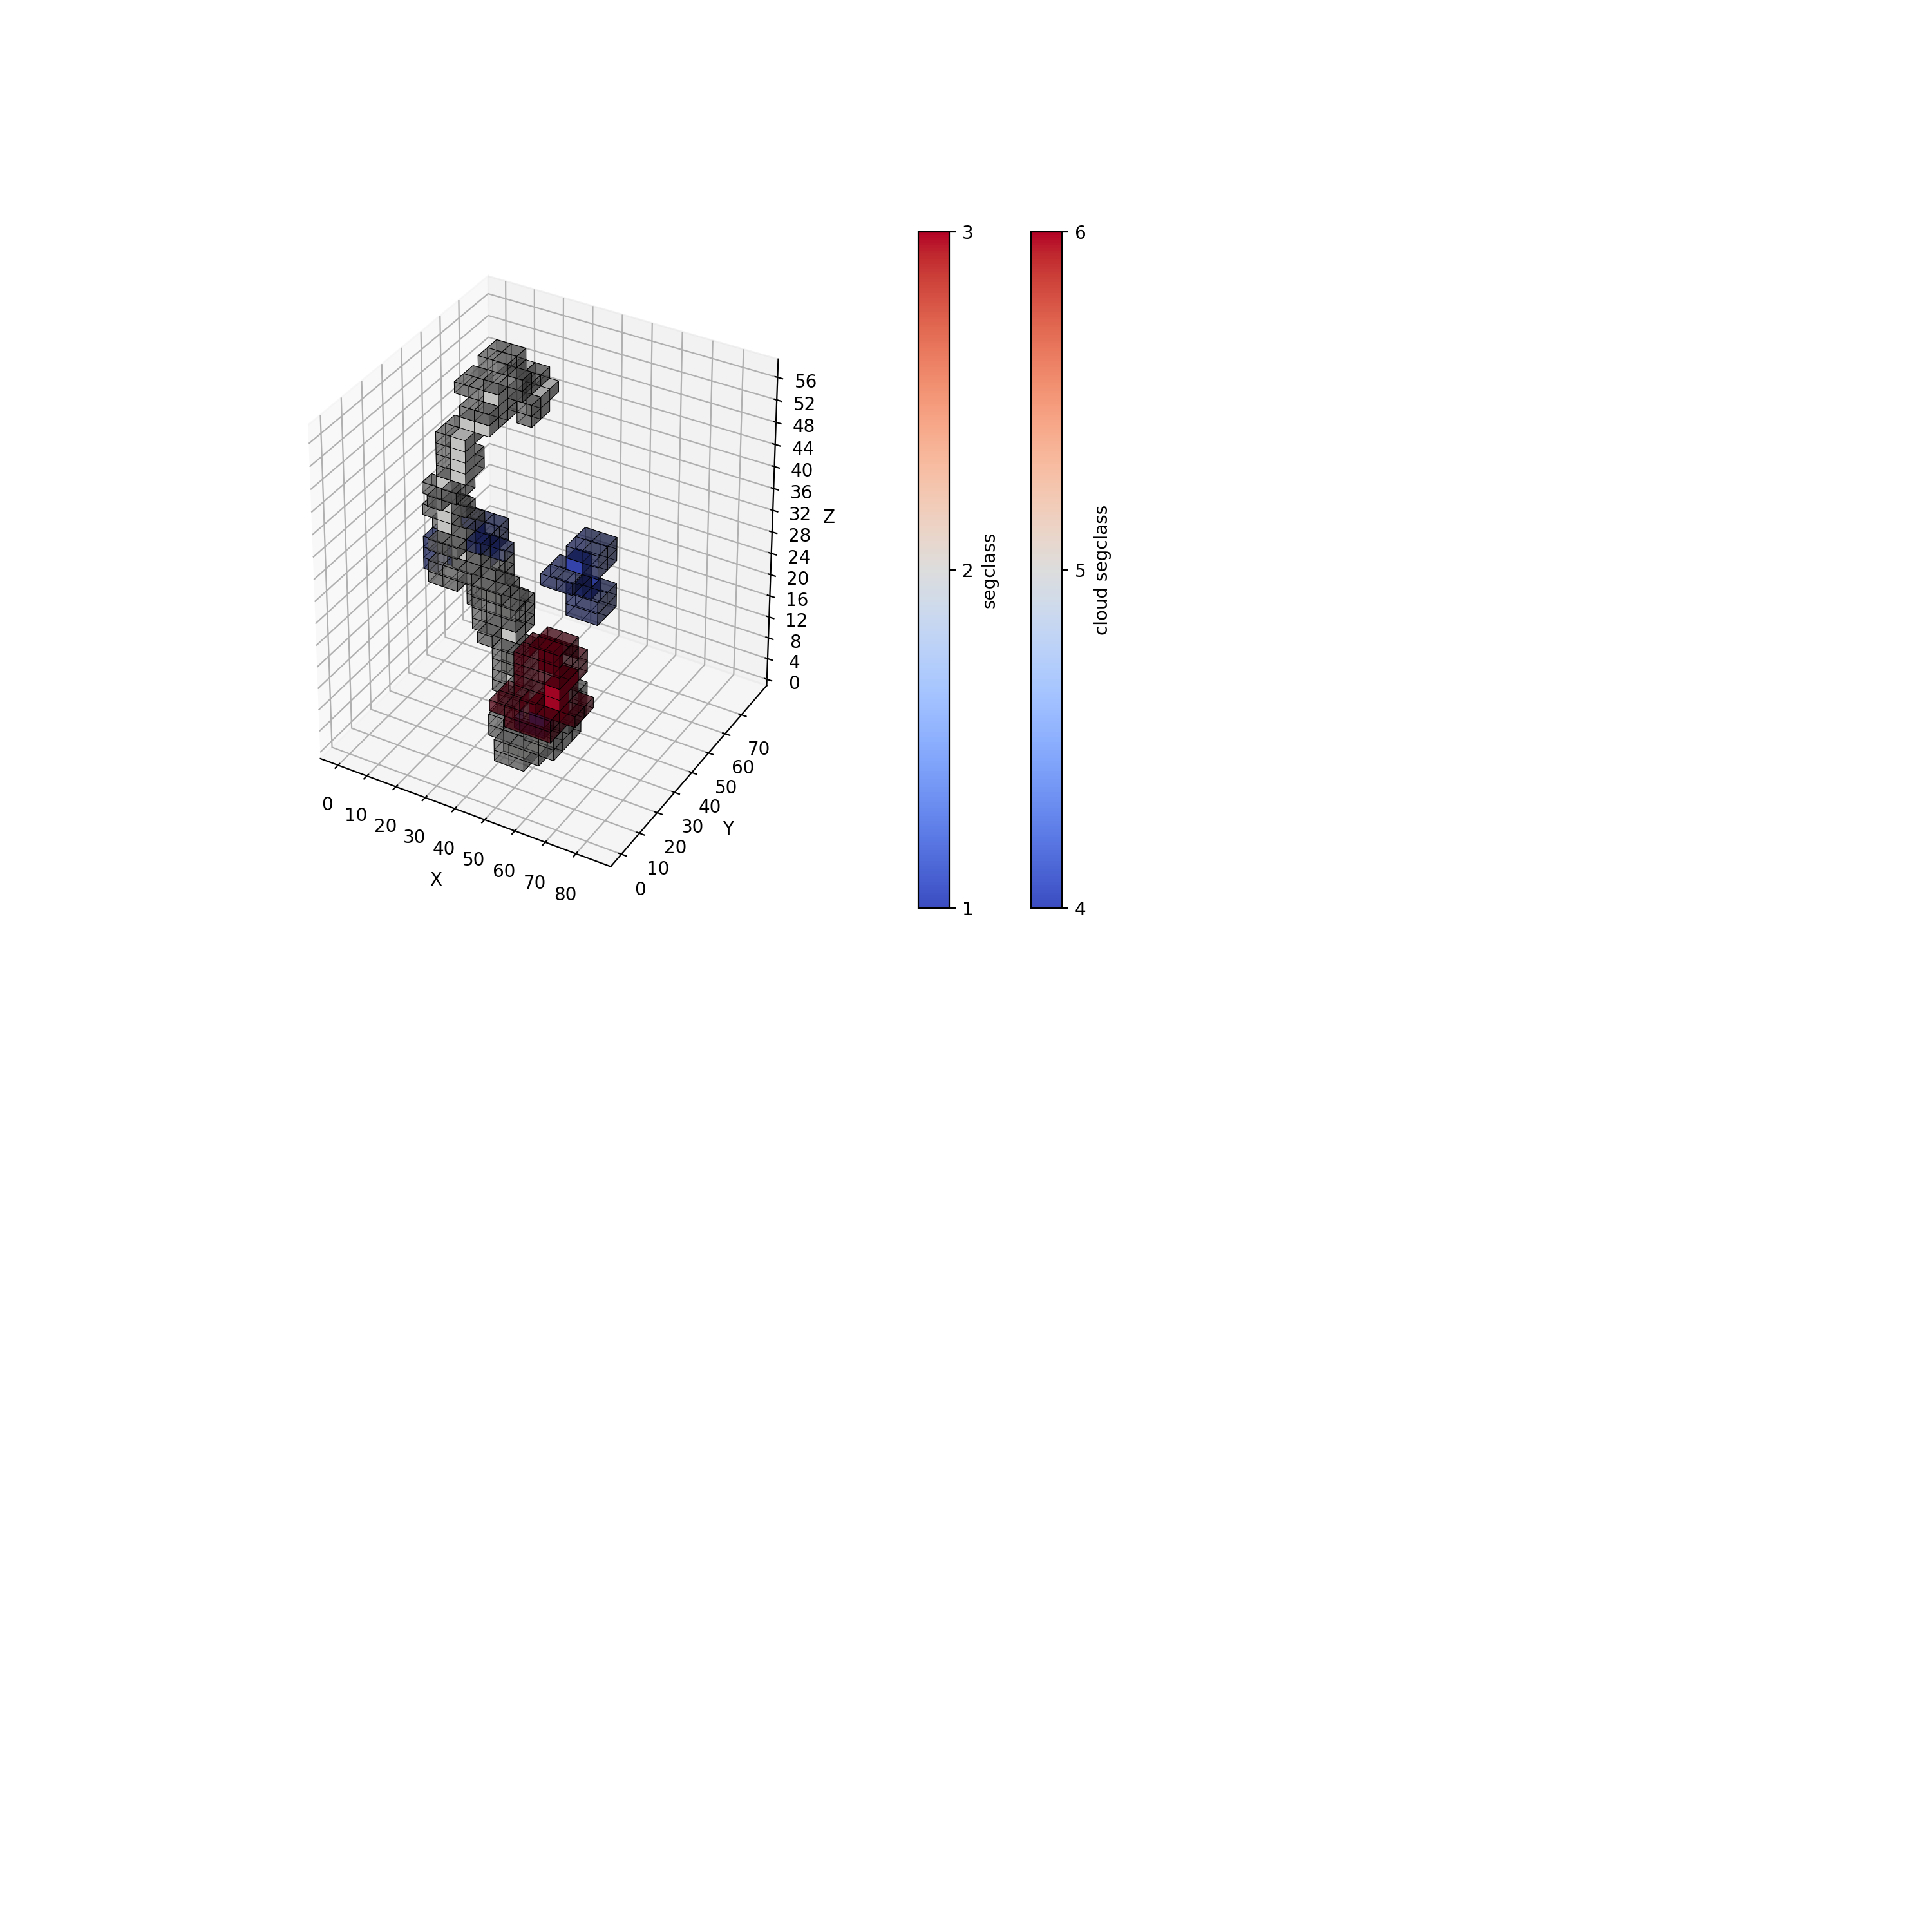

In [47]:
%matplotlib notebook

plot_cloud_voxels(event_vox, voxel_size, opacity = [1, 0.5])

#plot_cloud_voxels(final_event, opacity = [1, 0.5])
#plot_cloud_voxels(final_event2, opacity = [1, 0.5])
#plot_cloud_voxels(final_event3, opacity = [1, 0.5])
#plot_cloud_voxels(final_event4, opacity = [1, 0.5])
#plot_cloud_voxels(final_event5, opacity = [1, 0.5])

Some voxels (class 4 for example in this case) seem to be A BIT disconnected, because after the 2nd loop they seem more surrounded by class 5 than class 1, so they should be class 5 and not class 4. I've tried in another NB to fix this but I didn't like the solution, because it leaded to the predomination of the most abundant neighbour class. Another option is to kinda fix after the first iteration the blob neighbours for them to survive the loop, but the rest of them will be looping until they converge.... idk

Podemos mirar concretamente los vecinos de los voxeles 4 a ver que sucede con ellos... o los vecinos de los voxeles 1 a ver si se hacen bien, porque a simple vista no parece ://

El problema era la función de plot, ahor ya está solucionada y funciona correctamente.

# PROBLEMA CON LOS EVENTOS DESCONECTADOS

VALE, TENEMOS QUE ARREGLAR LOS EVENTOS QUE TIENEN COSAS DESCONECTADAS... En principio, los que tienen cosillas desconectadas pero que tienen dentro un voxel con segclass pura no deberían dar problemas (aunque el event4 parece que es de esos y si que da algún problema, no se exactamente cual...). Quizás dan problemas porque la posición no coincide exactamente entonces no le toca ningún vecino... pero eso se arreglaría con ir ampliando la distancia a los vecinos tras cierto numero de iteraciones no? O quizás guardando la info de los voxeles que no formen parte de la nube, rollo vale no me sirves porque no eres un voxel real PERO te voy a asignar una clase y te voy a usar para que también cuentes en las siguientes rondas para etiquetar a tus vecinos... de esa forma cubres todo el espacio SI O SI...

Los que son más ''preocupantes'' quizás son los que tienen una nube desconectada sin razón aparente (quizás la reconstrucción está mal hecha por el tamaño del config??? y por eso pasan esas cosas??? Non sei...). Si esta desconexión de la nada no es extraña, quizás hay que sacar una nueva segclass propia y punto idk...

Una forma de diferenciar unos y otros veo que puede ser por grafos... literalmente todo lo pienso con grafos y no tengo ni idea de usarlos pero ok

Para hacer ahora una función que me plotee los hits y luego alrededor los voxeles con su etiqueta pos voy a hacer una parte que está dentro de la función de labelling_MC porque necesito los hits labelleados y esta func solo me devuelve los voxeles labelleados. Una opción no muy dificil es tb cmbiar la función para que me devuelva hits y voxeles labelleados y punto...

In [42]:
labelled_hits

,event_id,x,y,z,hit_id,energy,segclass,binclass,dist_hits,cumdist,particle_name,creator_proc
0,48000024,26.949236,181.372101,285.124054,0,0.005104,1.0,0,0.0,0.0,gamma,RadioactiveDecay
1,48000024,26.678534,180.700729,285.803558,0,0.003391,1.0,0,0.0,0.0,e-,phot
2,48000024,26.359673,180.022491,286.443512,1,0.004142,1.0,0,0.0,0.0,e-,phot
3,48000024,25.943626,179.287827,286.973358,2,0.006741,1.0,0,0.0,0.0,e-,phot
4,48000024,25.443466,178.509872,287.325806,3,0.004898,1.0,0,0.0,0.0,e-,phot
...,...,...,...,...,...,...,...,...,...,...,...,...
143261,48000597,36.669090,-49.727203,304.841309,9,0.013409,1.0,0,0.0,0.0,e-,eIoni
143262,48000597,25.682772,-62.683788,345.306335,0,0.000678,1.0,0,0.0,0.0,gamma,eBrem
143263,48000597,25.682297,-62.685036,345.305359,0,0.002433,1.0,0,0.0,0.0,e-,phot
143264,48000597,26.329964,-63.877815,345.103729,0,0.000989,1.0,0,0.0,0.0,gamma,phot


In [63]:
event_hits = labelled_hits[labelled_hits.event_id == labelled_hits.event_id.unique()[5]]

In [64]:
#event_hits

In [65]:
final_event

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
521,48000026,0,-12,138,0.000526,0,NaN,NaN,5
522,48000026,0,-11,138,0.001182,0,NaN,NaN,5
523,48000026,0,-11,139,0.000335,0,NaN,NaN,5
524,48000026,0,-10,138,0.000171,0,NaN,NaN,4
525,48000026,0,-10,139,0.001879,0,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...
772,48000026,8,-16,138,0.003885,0,NaN,NaN,6
773,48000026,8,-16,139,0.000173,0,NaN,NaN,6
774,48000026,8,-15,136,0.000498,0,NaN,NaN,6
775,48000026,9,-18,138,0.001893,0,NaN,NaN,6


Los tengo que adaptar a las dimensiones de voxelizado, es decir, dividir por el tamaño de voxel cada coordenada para que entre en el frame y coincida con sus voxeles (los voxeles para su buen ploteado deben estar normalizados sí o sí...)

In [13]:
def plot_adaption_hits_to_voxel_scale(event_hits, voxel_size, coords = ['x', 'y', 'z']):
    '''
    We want to plot the MC hits in order to visualize better how the neighbour classes went, so this function 
    scales the positions for them to coincide.
    
    Args:
        event_hits: DATAFRAME
    Labelled MC hits of an event.
        
        voxel_size: TUPLE
    Contains the size of the voxel for each dimension.
        
        coords: LIST
    List with the coordinate names in the dataframe.
        
    RETURNS:
        event_scaled_hits: DATAFRAME
    Copy of the input DF but with scaled coordinates to the voxel size.        
    '''
    
    event_scaled_hits = event_hits.copy()
    for coor, size in zip(coords, voxel_size):
        event_scaled_hits[coor] = event_hits[coor] / size
    return event_scaled_hits

In [48]:
def plot_cloud_voxels_and_hits(labelled_voxels, labelled_hits, voxel_size, affluence = (2, 2, 2), value = ['segclass', 'segclass', 'segclass'], coords = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap = [mpl.cm.coolwarm, mpl.cm.coolwarm, mpl.cm.coolwarm], opacity = [0, 1]):
    '''
    This function is made to plot the neighbour labelled hits (the cloud) with some transparency, and the hits 
    inside this cloud, to see how they agree. This is better than using the MC labels because it's difficult to
    see something this way, so these voxels will be mainly transparent when using this.
    
    Args:
        labelled_voxels: DATAFRAME
    Output of one of the label_neighbours function. Contains all the voxeles labelled as pure MC class, their
    neighbours and the ghost class.
        
        labelled_hits: DATAFRAME
    Second output of the labelling_MC function. Contains the MC hits with their segclass.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate. Used to create the labels and scale the hits.
        
        affluence: TUPLE
    Separation parameter for the labels in each coordinate. If 1, labels will be plotted for each voxel step, 
    if 2, they will be plotted each 2 voxel steps, etc.
    
        value: LIST
    List with the wanted features to plot, for the MC and cloud voxels, and the hits: [MC, cloud, hits].
        
        coords: LIST
    List with the name of the coordinates in the dataframe to plot.
        
        th: FLOAT
    Minimum value to plot a voxel (usually used with the energy feature, to see the most energetic voxels).
        
        edgecolor: STR
    Color code of the matplotlib library to plot the edges of the voxel.
        
        linewidth: FLOAT
    Number to change width edges of the voxels.
        
        cmap: LIST
    List with the colormap from the matplotlib library to use with each kind of voxels/hits: [MC, cloud, hits].
        
        opacity: LIST
    List with numbers from 0 to 1 (being 0 transparent and 1 opac), for both kind of voxels: [MC, cloud].
    '''
    
    #Escojo el minimo y el maximo por coordenada de ambos DF, ya que si no un df se desplaza respecto a otro (probablemente)
    #De esta forma, el ''frame'' que calcula (nbins en cada coord) será el máximo siempre, y a las coordenadas a rellenar
    #le restamos el mínimo de ambos DF ya que si le restamos a cada uno por su cuenta se desplza que era lo que me pasaba
    #Entonces creo que con esto ya está la verdad
    
    xmin, xmax = labelled_voxels[coords[0]].min(), labelled_voxels[coords[0]].max()
    ymin, ymax = labelled_voxels[coords[1]].min(), labelled_voxels[coords[1]].max()
    zmin, zmax = labelled_voxels[coords[2]].min(), labelled_voxels[coords[2]].max()
    
    labels, ticks = plot_label_creator((xmin, ymin, zmin), (xmax, ymax, zmax), voxel_size, affluence)
    
    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    
    
    mc_label = labelled_voxels[np.isin(labelled_voxels.segclass, (1, 2, 3))]
    cloud    = labelled_voxels[~np.isin(labelled_voxels.segclass, (1, 2, 3))]
    
    #CLOUD
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([cloud[coords[0]].values-xmin,
                          cloud[coords[1]].values-ymin,
                          cloud[coords[2]].values-zmin])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = cloud[value[1]].values
    dim     = xarr.shape
    voxels  = xarr > th

    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 24])
    norm = mpl.colors.Normalize(vmin=cloud[value[1]].min(), vmax=cloud[value[1]].max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap[1])

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity[1], edgecolor=edgecolor, linewidth = linewidth)
    cb_cloud = mpl.colorbar.ColorbarBase(axcb, cmap=cmap[1], norm=norm, orientation='vertical')

    #MC 
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([mc_label[coords[0]].values-xmin,
                          mc_label[coords[1]].values-ymin,
                          mc_label[coords[2]].values-zmin])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = mc_label[value[0]].values
    dim     = xarr.shape
    voxels  = xarr > th
    
    #gs   = fig.add_gridspec(2, 40)
    #ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb  = fig.add_subplot(gs[0, 21])
    norm = mpl.colors.Normalize(vmin=mc_label[value[0]].min(), vmax=mc_label[value[0]].max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap[0])

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity[0], edgecolor=edgecolor, linewidth = linewidth)
    cb_mc = mpl.colorbar.ColorbarBase(axcb, cmap=cmap[0], norm=norm, orientation='vertical')
    
    #HITS
    scaled_hits = plot_adaption_hits_to_voxel_scale(labelled_hits, voxel_size)
    
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=scaled_hits.loc[:, value[2]].min(), vmax=scaled_hits.loc[:, value[2]].max())

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap[2])

    colors = np.asarray(np.vectorize(m.to_rgba)(scaled_hits.loc[:, value[2]]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(scaled_hits[coords[0]] - xmin, scaled_hits[coords[1]] - ymin, scaled_hits[coords[2]] - zmin, c=colors, marker='o')
    cb_hits = mpl.colorbar.ColorbarBase(axcb, cmap=cmap[2], norm=norm, orientation='vertical')
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    
    ax.set_xticklabels(labels[0])
    ax.set_xticks(ticks[0])
    ax.set_yticklabels(labels[1])
    ax.set_yticks(ticks[1])
    ax.set_zticklabels(labels[2])
    ax.set_zticks(ticks[2])
    
    if value[1] == 'segclass':
        cb_cloud.set_ticks([4, 5, 6])
        cb_cloud.set_ticklabels([4, 5, 6])
    cb_cloud.set_label('cloud ' + value[1])
    
    if value[0] == 'segclass':
        cb_mc.set_ticks([1, 2, 3])
        cb_mc.set_ticklabels([1, 2, 3])
    cb_mc.set_label(value[0])
    
    if value[2] == 'segclass':
        cb_hits.set_ticks([1, 2, 3])
        cb_hits.set_ticklabels([1, 2, 3])
    cb_hits.set_label('hits ' + value[2])
    
    plt.show()

<IPython.core.display.Javascript object>


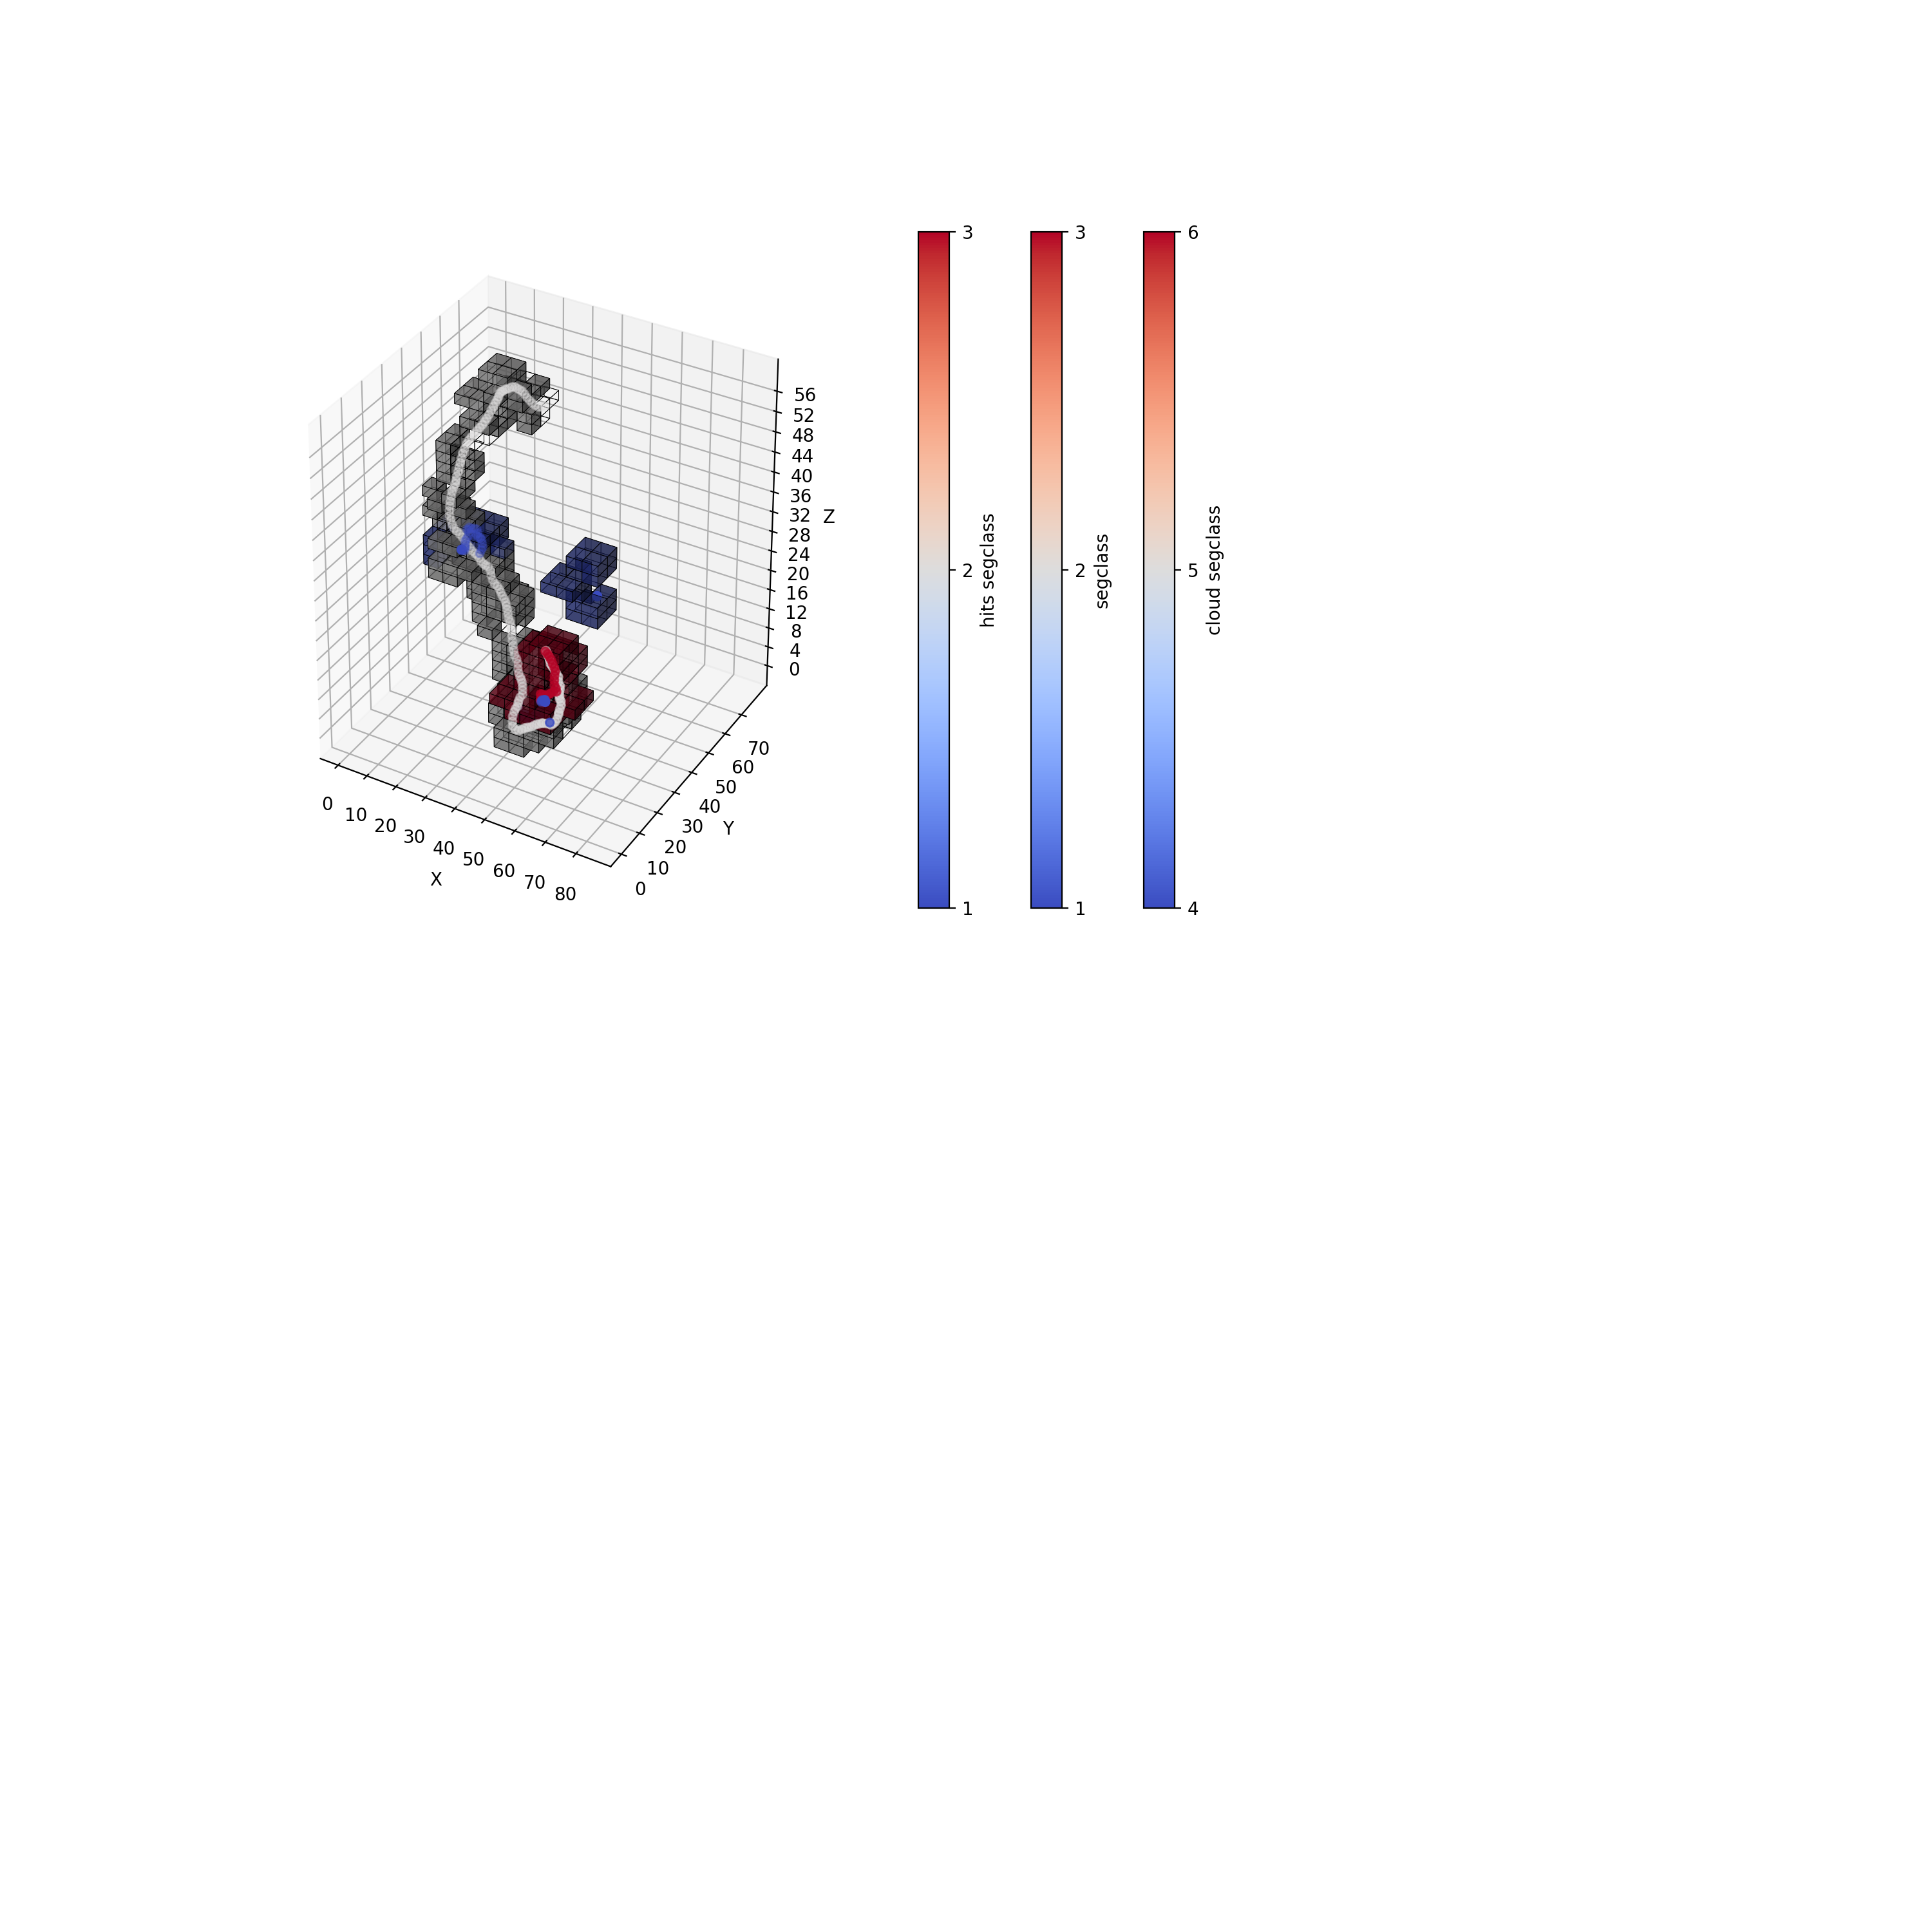

In [49]:
plot_cloud_voxels_and_hits(event_vox, event_hits, voxel_size, opacity = [0, 0.6])